# RFBD Best Patterns Analysis

This notebook samples perfect matches from `rating_to_rfbd_mapping_enhanced.csv`, loads the latest acceleration CSVs from `rfdb_csvs`, computes time-domain and spectral features, and identifies patterns linked to the best scores.

In [100]:
# 1. Set Up Environment and Paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import json

# Optional: use scipy/sklearn if available; handle absence gracefully
try:
    from scipy.signal import welch
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    from sklearn.model_selection import cross_val_score
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 150

# Paths (robust discovery)
base_dir = Path('.').resolve()
parent_dir = base_dir.parent

# Try to locate mapping CSV by common names in current or parent
candidate_names = [
    'rating_to_rfbd_mapping_enhanced.csv',
    'rating_to_rfbd_mapping.csv',
    'rfbd_mapping.csv',
    'rfdb_mapping.csv',
    'complete_coaster_mapping.csv'
]
mapping_csv = None
for name in candidate_names:
    for root in [base_dir, parent_dir]:
        p = root / name
        if p.exists():
            mapping_csv = p
            break
    if mapping_csv:
        break
if mapping_csv is None:
    # Last resort: glob search in workspace
    hits = list(base_dir.glob('**/*mapping*.csv')) + list(parent_dir.glob('**/*mapping*.csv'))
    mapping_csv = hits[0] if hits else None

# RFBD directory discovery (rfdb_csvs or rfbd_csvs)
rfdb_dir = None
for cand in ['rfdb_csvs','rfbd_csvs','RFDB_CSVS','RFBD_CSVS']:
    for root in [base_dir, parent_dir]:
        p = root / cand
        if p.exists() and p.is_dir():
            rfdb_dir = p
            break
    if rfdb_dir:
        break

# Figures directory
fig_dir = (base_dir / 'figures')
fig_dir.mkdir(exist_ok=True)

# Sampling control
SAMPLE_LIMIT = 200  # reduce if runtime/memory is tight
np.random.seed(42)

print('Environment ready.')
print('Base:', base_dir)
print('Mapping CSV:', str(mapping_csv) if mapping_csv else 'NOT FOUND')
print('RFBD dir:', str(rfdb_dir) if rfdb_dir else 'NOT FOUND')

Environment ready.
Base: C:\Users\Lenovo\rollercoaster\ratings_data
Mapping CSV: C:\Users\Lenovo\rollercoaster\ratings_data\complete_coaster_mapping.csv
RFBD dir: C:\Users\Lenovo\rollercoaster\rfdb_csvs


In [101]:
# 2. Load Mapping Data and Sample Perfect Matches (using provided columns)
assert mapping_csv and mapping_csv.exists(), f"Mapping CSV not found: {mapping_csv}"
map_df = pd.read_csv(mapping_csv)

# Column names per user:
# coaster_id, ratings_coaster, ratings_park, rfdb_coaster_folder, rfdb_park_folder, csv_count, full_path,
# coaster_similarity, park_similarity, combined_similarity, match_reason, match_type

# Required field mapping
status_col = 'match_type' if 'match_type' in map_df.columns else None
score_col = 'combined_similarity' if 'combined_similarity' in map_df.columns else None
key_col = 'full_path' if 'full_path' in map_df.columns else ('rfdb_coaster_folder' if 'rfdb_coaster_folder' in map_df.columns else None)
id_col = 'coaster_id' if 'coaster_id' in map_df.columns else None

assert status_col and key_col and score_col, "Required columns missing: need match_type, key (full_path/rfdb_coaster_folder), and combined_similarity"

# Filter perfect matches
perfect_df = map_df[map_df[status_col].astype(str).str.lower() == 'perfect'].copy()
perfect_df[score_col] = pd.to_numeric(perfect_df[score_col], errors='coerce')
perfect_df = perfect_df.dropna(subset=[score_col, key_col])

# Sample subset
if len(perfect_df) > SAMPLE_LIMIT:
    perfect_df = perfect_df.sample(SAMPLE_LIMIT, random_state=42)

keep_cols = [c for c in [id_col, key_col, score_col, 'csv_count'] if c and c in perfect_df.columns]
perfect_df = perfect_df[keep_cols]
print(f"Perfect matches sampled: {len(perfect_df)}")

Perfect matches sampled: 200


In [102]:
perfect_df

,coaster_id,full_path,combined_similarity,csv_count
319,125,rfdb_csvs\altontowers\oblivion,98.7,3
227,2376,rfdb_csvs\niagaraamusementpark\silvercomet,87.0,3
13,2798,rfdb_csvs\walibiholland\untamed,98.4,1
133,6075,rfdb_csvs\mandoria\aquila,100.0,5
1023,537,rfdb_csvs\worldsoffun\boomerang,95.7,1
...,...,...,...,...
358,706,rfdb_csvs\canadaswonderland\vortex,97.9,5
803,2157,rfdb_csvs\funspotamericaorlando\freedomflyer,92.7,2
847,695,rfdb_csvs\canadaswonderland\dragonfyre,94.5,2
897,2801,rfdb_csvs\valleyfair\corkscrew,100.0,1


In [103]:
# 3. Resolve File Paths to Latest Acceleration CSVs (use full_path folder; pick last CSV; avoid double rfdb_csvs)
import os
rows = []
fail_samples = []

assert rfdb_dir and Path(rfdb_dir).exists(), f"RFBD directory not found: {rfdb_dir}"
assert 'full_path' in perfect_df.columns, "Column 'full_path' must be present to locate CSVs"

rfdb_dir = Path(rfdb_dir).resolve()
rfdb_name = rfdb_dir.name.lower()


def normalize_rel_dir(val):
    if pd.isna(val):
        return ''
    s = str(val).strip().strip('"').strip("'")
    # Normalize separators
    s = s.replace('\\', os.sep).replace('/', os.sep)
    # If the path is absolute, return as-is
    if os.path.isabs(s):
        return s
    # Remove leading separators to keep it relative
    while s.startswith(os.sep):
        s = s[len(os.sep):]
    # If the relative path starts with rfdb_csvs already, strip that prefix
    parts = s.split(os.sep)
    if parts and parts[0].lower() == rfdb_name:
        s = os.sep.join(parts[1:])
    return s


def resolve_latest_in_full_path_folder(r):
    raw = r['full_path']
    rel = normalize_rel_dir(raw)
    if not rel:
        return None, {'reason': 'empty-full_path', 'raw': raw}
    # Decide folder: absolute provided or join with rfdb_dir
    folder = Path(rel).resolve() if os.path.isabs(rel) else (rfdb_dir / rel).resolve()
    try:
        if folder.exists() and folder.is_dir():
            csvs = sorted([str(fp) for fp in folder.glob('*.csv')])
            if not csvs:
                # In case CSVs are nested one level deeper
                csvs = sorted([str(fp) for fp in folder.glob('**/*.csv')])
            if csvs:
                return csvs[-1], {'reason': 'ok', 'rel': rel, 'folder': str(folder), 'count': len(csvs)}
            else:
                return None, {'reason': 'dir-no-csv', 'rel': rel, 'folder': str(folder)}
        else:
            return None, {'reason': 'not-found', 'rel': rel, 'folder': str(folder)}
    except Exception as e:
        return None, {'reason': 'exception', 'error': str(e), 'rel': rel, 'folder': str(folder)}

# Quick diagnostics for first few entries
print('Diagnostics: rfdb_dir =', rfdb_dir)
for i, (_, r) in enumerate(perfect_df.head(5).iterrows()):
    rel = normalize_rel_dir(r['full_path'])
    folder = Path(rel).resolve() if os.path.isabs(rel) else (rfdb_dir / rel).resolve()
    print(f"[Diag {i+1}] full_path='{r['full_path']}' -> folder='{folder}' exists={folder.exists()} is_dir={folder.is_dir()}")

for _, r in perfect_df.iterrows():
    latest, info = resolve_latest_in_full_path_folder(r)
    if latest:
        rows.append({'key': r['full_path'], 'file': latest})
    else:
        if len(fail_samples) < 5:
            fail_samples.append(info)

path_df = pd.DataFrame(rows)
print(f"path_df rows: {len(path_df)}")
if len(path_df):
    print(path_df.head())
else:
    print('No paths resolved. Sample failures:', fail_samples[:3])

Diagnostics: rfdb_dir = C:\Users\Lenovo\rollercoaster\rfdb_csvs
[Diag 1] full_path='rfdb_csvs\altontowers\oblivion' -> folder='C:\Users\Lenovo\rollercoaster\rfdb_csvs\altontowers\oblivion' exists=True is_dir=True
[Diag 2] full_path='rfdb_csvs\niagaraamusementpark\silvercomet' -> folder='C:\Users\Lenovo\rollercoaster\rfdb_csvs\niagaraamusementpark\silvercomet' exists=True is_dir=True
[Diag 3] full_path='rfdb_csvs\walibiholland\untamed' -> folder='C:\Users\Lenovo\rollercoaster\rfdb_csvs\walibiholland\untamed' exists=True is_dir=True
[Diag 4] full_path='rfdb_csvs\mandoria\aquila' -> folder='C:\Users\Lenovo\rollercoaster\rfdb_csvs\mandoria\aquila' exists=True is_dir=True
[Diag 5] full_path='rfdb_csvs\worldsoffun\boomerang' -> folder='C:\Users\Lenovo\rollercoaster\rfdb_csvs\worldsoffun\boomerang' exists=True is_dir=True


path_df rows: 200
                                          key  \
0              rfdb_csvs\altontowers\oblivion   
1  rfdb_csvs\niagaraamusementpark\silvercomet   
2             rfdb_csvs\walibiholland\untamed   
3                   rfdb_csvs\mandoria\aquila   
4             rfdb_csvs\worldsoffun\boomerang   

                                                file  
0  C:\Users\Lenovo\rollercoaster\rfdb_csvs\altont...  
1  C:\Users\Lenovo\rollercoaster\rfdb_csvs\niagar...  
2  C:\Users\Lenovo\rollercoaster\rfdb_csvs\walibi...  
3  C:\Users\Lenovo\rollercoaster\rfdb_csvs\mandor...  
4  C:\Users\Lenovo\rollercoaster\rfdb_csvs\worlds...  


In [104]:
# Merge resolved paths back to perfect_df

resolved_df = perfect_df.merge(path_df, left_on=key_col, right_on='key', how='inner')
print(f"Resolved files: {len(resolved_df)} of {len(perfect_df)}")
if fail_samples:
    print("Sample failures (up to 5):")
    for i, fs in enumerate(fail_samples, 1):
        print(f"[{i}]", fs)
print(resolved_df.head())

Resolved files: 244 of 200
   coaster_id                                   full_path  \
0         125              rfdb_csvs\altontowers\oblivion   
1        2376  rfdb_csvs\niagaraamusementpark\silvercomet   
2        2798             rfdb_csvs\walibiholland\untamed   
3        6075                   rfdb_csvs\mandoria\aquila   
4         537             rfdb_csvs\worldsoffun\boomerang   

   combined_similarity  csv_count                                         key  \
0                 98.7          3              rfdb_csvs\altontowers\oblivion   
1                 87.0          3  rfdb_csvs\niagaraamusementpark\silvercomet   
2                 98.4          1             rfdb_csvs\walibiholland\untamed   
3                100.0          5                   rfdb_csvs\mandoria\aquila   
4                 95.7          1             rfdb_csvs\worldsoffun\boomerang   

                                                file  
0  C:\Users\Lenovo\rollercoaster\rfdb_csvs\altont...  
1  C:\Use

In [105]:
# 4. Load and Preprocess Acceleration Data

def load_accel_csv(fp: Path):
    df = pd.read_csv(fp)
    cols = [c.lower() for c in df.columns]
    col_map = {c.lower(): c for c in df.columns}
    # Try to infer axes/time columns
    time_col = 'time' if 'time' in cols else ('t' if 't' in cols else None)
    ax_col = 'ax' if 'ax' in cols else ('a_x' if 'a_x' in cols else None)
    ay_col = 'ay' if 'ay' in cols else ('a_y' if 'a_y' in cols else None)
    az_col = 'az' if 'az' in cols else ('a_z' if 'a_z' in cols else None)
    # Fallback: look for common names
    if not ax_col:
        for cand in ['gx','lat','acc_x']: ax_col = cand if cand in cols else ax_col
    if not ay_col:
        for cand in ['gy','long','acc_y']: ay_col = cand if cand in cols else ay_col
    if not az_col:
        for cand in ['gz','vert','acc_z']: az_col = cand if cand in cols else az_col

    # Build output
    out = pd.DataFrame()
    if time_col:
        out['time'] = pd.to_numeric(df[col_map[time_col]], errors='coerce')
    else:
        out['time'] = np.arange(len(df)) * 0.02  # 50 Hz default
    for name, col in [('ax', ax_col), ('ay', ay_col), ('az', az_col)]:
        if col:
            out[name] = pd.to_numeric(df[col_map[col]], errors='coerce')
        else:
            out[name] = 0.0
    out = out.dropna().drop_duplicates(subset=['time']).sort_values('time')
    # Normalize axes to zero mean
    for name in ['ax','ay','az']:
        m = out[name].mean()
        out[name] = out[name] - m
        # Clip 3-sigma outliers
        s = out[name].std(ddof=1)
        if s > 0:
            out[name] = out[name].clip(m-3*s, m+3*s)
    return out.reset_index(drop=True)

# Test one if available
print("Loader ready. First file:", resolved_df['file'].iloc[0] if len(resolved_df) else 'N/A')

Loader ready. First file: C:\Users\Lenovo\rollercoaster\rfdb_csvs\altontowers\oblivion\1724235400_978.csv


In [106]:
# 5. Compute Acceleration Magnitude and Basic Features (robust to empty/short signals)
from math import sqrt

def moving_average(arr, win=21):
    win = max(3, int(win))
    if len(arr) == 0 or win <= 0:
        return np.array([])
    # Ensure window does not exceed array length
    win = min(win, max(1, len(arr)))
    kernel = np.ones(win) / win
    return np.convolve(arr, kernel, mode='same')

def compute_features(df):
    if df is None or len(df) == 0:
        return {
            'len': 0,
            'mean_mag': np.nan,
            'std_mag': np.nan,
            'rms_mag': np.nan,
            'p2p_mag': np.nan,
            'q90_mag': np.nan,
            'q10_mag': np.nan,
            'jerk_rms': np.nan,
            'time_mag_gt_3g': np.nan,
            'time_mag_gt_4g': np.nan,
        }, np.array([]), np.array([])
    # magnitude
    amag = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
    # window scaled to signal length; ensure >=3 and <= len
    win = max(3, len(df)//200)
    amag_s = moving_average(amag, win=win)
    # basic stats
    feats = {
        'len': len(df),
        'mean_mag': float(np.mean(amag)) if len(amag) else np.nan,
        'std_mag': float(np.std(amag, ddof=1)) if len(amag) > 1 else np.nan,
        'rms_mag': float(np.sqrt(np.mean(amag**2))) if len(amag) else np.nan,
        'p2p_mag': float(np.ptp(amag)) if len(amag) else np.nan,
        'q90_mag': float(np.percentile(amag, 90)) if len(amag) else np.nan,
        'q10_mag': float(np.percentile(amag, 10)) if len(amag) else np.nan,
    }
    # jerk approx (finite diff)
    dt = np.median(np.diff(df['time'])) if len(df) > 1 else 0.02
    jerk = np.diff(amag_s) / max(dt, 1e-6) if len(amag_s) > 1 else np.array([])
    feats['jerk_rms'] = float(np.sqrt(np.mean(jerk**2))) if len(jerk) else np.nan
    # threshold durations (comfort heuristic)
    feats['time_mag_gt_3g'] = float(np.sum(amag > 3.0) * dt) if len(amag) else np.nan
    feats['time_mag_gt_4g'] = float(np.sum(amag > 4.0) * dt) if len(amag) else np.nan
    return feats, np.asarray(amag), np.asarray(amag_s)

print("Feature functions ready.")

Feature functions ready.


In [107]:
# 6. Spectral Feature Extraction (Welch PSD)

def spectral_features(amag, fs):
    if SCIPY_AVAILABLE and len(amag) > 8:
        f, Pxx = welch(amag, fs=fs, nperseg=min(1024, len(amag)))
        P = Pxx / (np.sum(Pxx) + 1e-12)
        # band powers
        def band_power(flo, fhi):
            idx = (f >= flo) & (f <= fhi)
            return float(np.sum(Pxx[idx]))
        dom_idx = int(np.argmax(Pxx))
        dom_f = float(f[dom_idx])
        # spectral entropy
        H = float(-np.sum(P * np.log(P + 1e-12)))
        # roll-off 85%
        cumsum = np.cumsum(Pxx) / (np.sum(Pxx) + 1e-12)
        roll_idx = int(np.searchsorted(cumsum, 0.85))
        roll_f = float(f[min(roll_idx, len(f)-1)])
        return {
            'psd_dom_f': dom_f,
            'psd_entropy': H,
            'psd_rolloff85': roll_f,
            'psd_low': band_power(0.1, 1.0),
            'psd_mid': band_power(1.0, 3.0),
            'psd_high': band_power(3.0, 10.0),
        }, f, Pxx
    else:
        return {
            'psd_dom_f': np.nan,
            'psd_entropy': np.nan,
            'psd_rolloff85': np.nan,
            'psd_low': np.nan,
            'psd_mid': np.nan,
            'psd_high': np.nan,
        }, np.array([]), np.array([])

print("Spectral functions ready.")

Spectral functions ready.


In [108]:
# 7. Aggregate Features Per Sample and Join Scores (skip empty loads)
feature_rows = []
traces = {}  # store time and amag for visualization

if len(resolved_df) == 0:
    print("No resolved files; skipping feature computation.")
else:
    for _, row in resolved_df.iterrows():
        fp = Path(row['file'])
        dfa = load_accel_csv(fp)
        if dfa is None or len(dfa) == 0:
            continue
        feats, amag, amag_s = compute_features(dfa)
        fs = 1.0 / max(np.median(np.diff(dfa['time'])), 1e-6)
        sfeats, f, Pxx = spectral_features(amag_s, fs)
        all_feats = {**feats, **sfeats}
        all_feats[key_col] = row[key_col]
        all_feats[score_col] = float(row[score_col])
        feature_rows.append(all_feats)
        traces[row[key_col]] = {'time': dfa['time'].to_numpy(), 'amag': amag_s}

features_df = pd.DataFrame(feature_rows)
print(f"Features computed for {len(features_df)} samples.")

# Standardize for analysis if sklearn available
if SKLEARN_AVAILABLE and len(features_df) > 0:
    num_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) > 0:
        scaler = StandardScaler()
        features_df[num_cols] = scaler.fit_transform(features_df[num_cols].fillna(0))

# Persist features only if non-empty
out_csv = base_dir / 'rfbd_features.csv'
if len(features_df) > 0:
    features_df.to_csv(out_csv, index=False)
    print(f"Saved features to {out_csv}")
else:
    print("No features to save.")

Features computed for 240 samples.
Saved features to C:\Users\Lenovo\rollercoaster\ratings_data\rfbd_features.csv


Top correlations to score:
 combined_similarity    1.000000
len                    0.231365
mean_mag                    NaN
std_mag                     NaN
rms_mag                     NaN
p2p_mag                     NaN
q90_mag                     NaN
q10_mag                     NaN
jerk_rms                    NaN
time_mag_gt_3g              NaN
Name: combined_similarity, dtype: float64
RandomForest CV mae-like score (R^2): mean=-0.820, std=0.458
RandomForest CV mae-like score (R^2): mean=-0.820, std=0.458


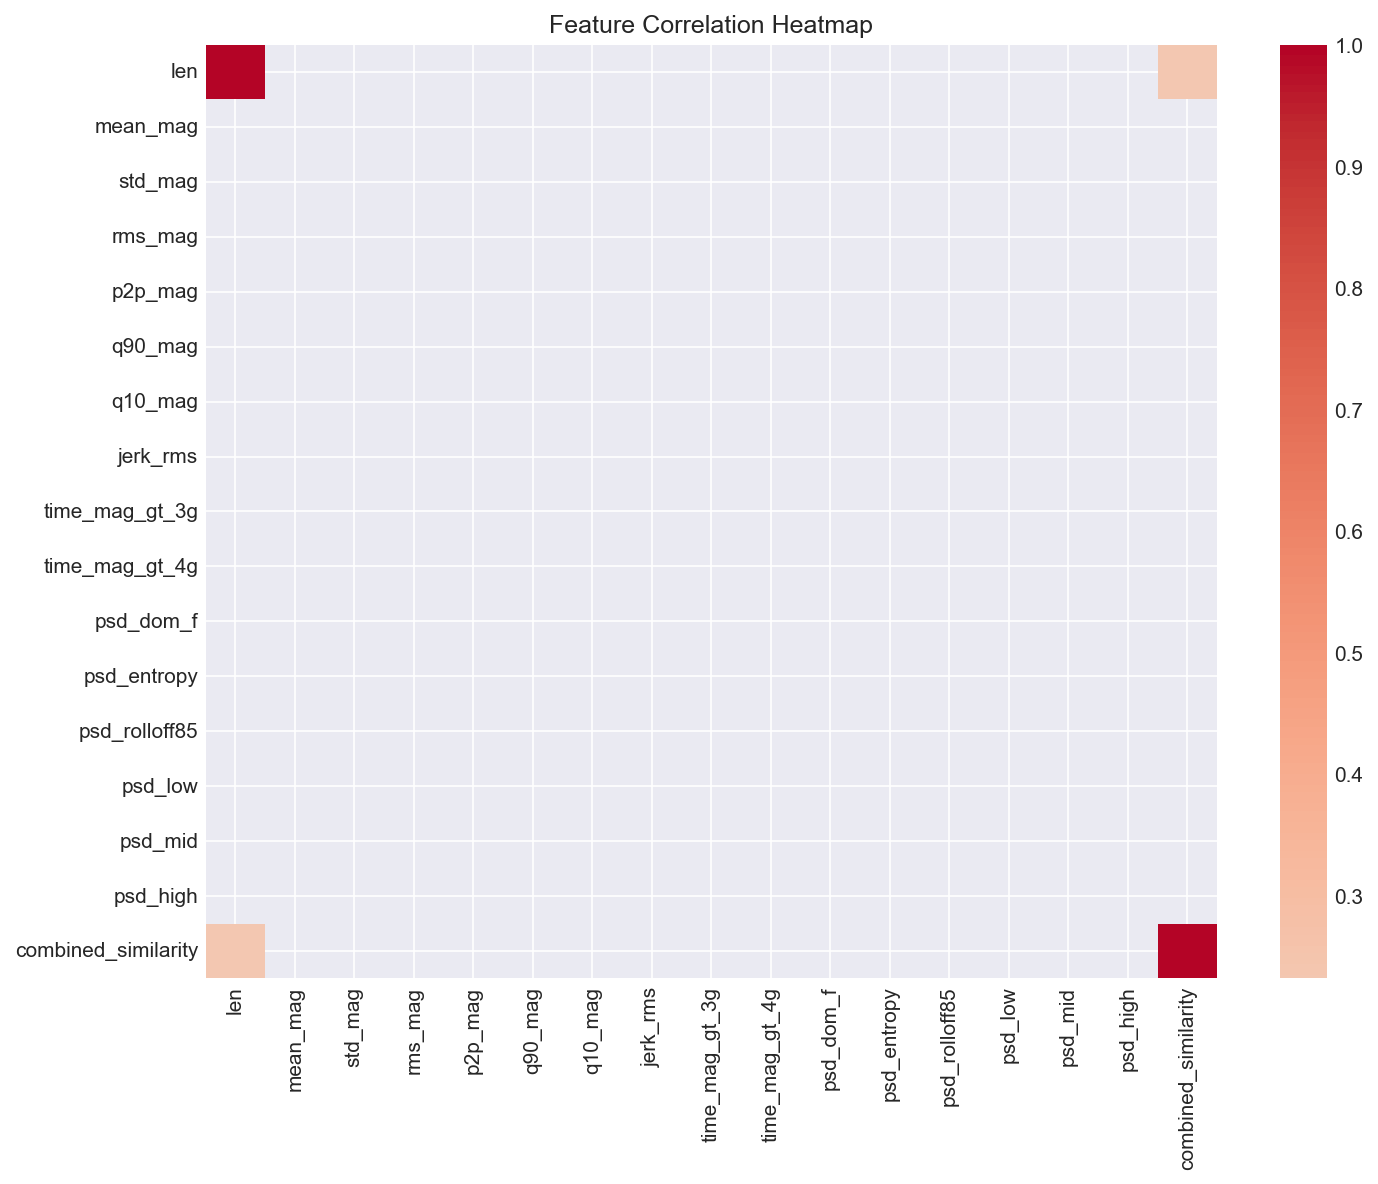

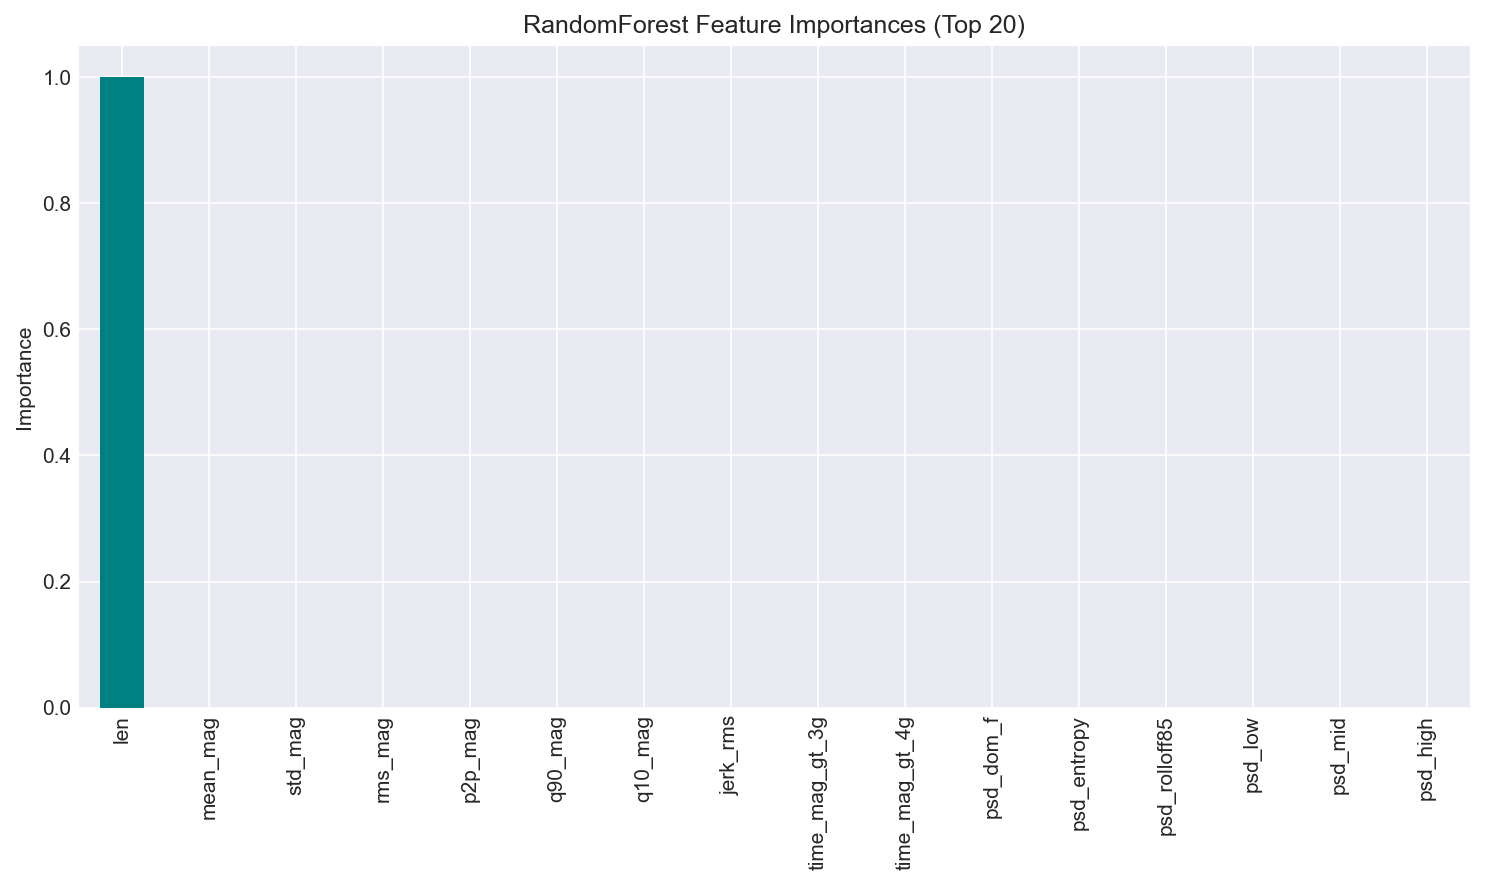

ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


In [109]:
# 8. Pattern Discovery: Correlations and Feature Importance (guard empty features)
corr_df = features_df.copy()

if len(features_df) == 0:
    print("No features; skipping correlation and RF analysis.")
else:
    # Pearson correlation
    corr = corr_df.corr(numeric_only=True)
    if score_col in corr.columns:
        score_corr = corr[score_col].sort_values(ascending=False)
        print("Top correlations to score:\n", score_corr.head(10))
    else:
        print(f"Score column '{score_col}' not in correlation matrix.")

    # Random forest feature importance
    rf_importances = None
    if SKLEARN_AVAILABLE and len(features_df) > 10:
        X = features_df.drop(columns=[score_col, key_col]).select_dtypes(include=[np.number]).fillna(0)
        y = features_df[score_col].astype(float)
        if len(X.columns) > 0:
            rf = RandomForestRegressor(n_estimators=200, random_state=42)
            rf.fit(X, y)
            rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
            # CV score
            cv = cross_val_score(rf, X, y, cv=3)
            print(f"RandomForest CV mae-like score (R^2): mean={cv.mean():.3f}, std={cv.std():.3f}")
        else:
            print("No numeric feature columns for RF.")
    else:
        print("SKLearn not available or not enough samples; skipping RF feature importance.")

    # Visuals
    import plotly.graph_objects as go
    if 'corr' in locals():
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(corr, ax=ax, cmap='coolwarm', center=0)
        ax.set_title('Feature Correlation Heatmap')
        plt.tight_layout()
        plt.savefig(fig_dir / 'corr_heatmap.png', dpi=300)
        plt.show()

    if 'rf_importances' in locals() and rf_importances is not None:
        fig, ax = plt.subplots(figsize=(10, 6))
        rf_importances.head(20).plot(kind='bar', ax=ax, color='teal')
        ax.set_title('RandomForest Feature Importances (Top 20)')
        ax.set_ylabel('Importance')
        plt.tight_layout()
        plt.savefig(fig_dir / 'rf_importances.png', dpi=300)
        plt.show()

    # Overlay time-domain traces for top-5 scoring
    if score_col in features_df.columns and key_col in features_df.columns:
        top_keys = features_df.sort_values(score_col, ascending=False)[key_col].head(5).tolist()
        fig = go.Figure()
        for k in top_keys:
            tr = traces.get(k)
            if tr:
                fig.add_trace(go.Scatter(x=tr['time'], y=tr['amag'], mode='lines', name=str(k)))
        fig.update_layout(title='Top-5 Scoring: Acceleration Magnitude Traces', xaxis_title='Time (s)', yaxis_title='a_mag (smoothed)')
        fig.write_image(str(fig_dir / 'top5_traces.png'))
        fig.show()

    # PSD curves for top vs median
    if SCIPY_AVAILABLE and score_col in features_df.columns and key_col in features_df.columns and len(features_df) > 0:
        med_key = features_df.sort_values(score_col).iloc[len(features_df)//2][key_col]
        fig_psd = go.Figure()
        if len(features_df) > 0:
            top_keys = features_df.sort_values(score_col, ascending=False)[key_col].head(1).tolist()
            for k,color in [(top_keys[0],'red'), (med_key,'gray')]:
                tr = traces.get(k)
                if tr and len(tr['time']) > 1:
                    fs = 1.0 / max(np.median(np.diff(tr['time'])), 1e-6)
                    f, Pxx = welch(tr['amag'], fs=fs, nperseg=min(1024, len(tr['amag'])))
                    fig_psd.add_trace(go.Scatter(x=f, y=Pxx, mode='lines', name=str(k), line=dict(color=color)))
        fig_psd.update_layout(title='PSD: Top vs Median', xaxis_title='Frequency (Hz)', yaxis_title='PSD')
        fig_psd.write_image(str(fig_dir / 'psd_top_vs_median.png'))
        fig_psd.show()

In [110]:
# 9. Persist Outputs (CSV and Figures) and Summary Report (guard empty features)
summary_cols = [key_col, score_col, 'len','mean_mag','std_mag','rms_mag','psd_dom_f','psd_entropy','psd_rolloff85']

if len(features_df) > 0:
    summary_df = features_df[[c for c in summary_cols if c in features_df.columns]].copy()
    summary_path = base_dir / 'rfbd_summary.csv'
    summary_df.to_csv(summary_path, index=False)
else:
    summary_df = pd.DataFrame()
    summary_path = base_dir / 'rfbd_summary.csv'

# Safe defaults if upstream sections were skipped
if 'score_corr' not in locals():
    score_corr = pd.Series(dtype=float)
if 'rf_importances' not in locals():
    rf_importances = None

report = {
    'samples': int(len(features_df)),
    'top_correlations': (score_corr.head(10).to_dict() if len(score_corr) > 0 else {}),
    'rf_top_features': (rf_importances.head(15).to_dict() if rf_importances is not None else {}),
    'files_saved': {
        'features_csv': str(base_dir / 'rfbd_features.csv'),
        'summary_csv': str(summary_path),
        'corr_heatmap': str(fig_dir / 'corr_heatmap.png'),
        'rf_importances': str(fig_dir / 'rf_importances.png'),
        'top5_traces': str(fig_dir / 'top5_traces.png'),
        'psd_top_vs_median': str(fig_dir / 'psd_top_vs_median.png'),
    }
}

with open(base_dir / 'rfbd_analysis_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("✓ Analysis complete. Outputs saved:")
print(json.dumps(report, indent=2))

✓ Analysis complete. Outputs saved:
{
  "samples": 240,
  "top_correlations": {
    "combined_similarity": 1.0,
    "len": 0.23136483731314428,
    "mean_mag": NaN,
    "std_mag": NaN,
    "rms_mag": NaN,
    "p2p_mag": NaN,
    "q90_mag": NaN,
    "q10_mag": NaN,
    "jerk_rms": NaN,
    "time_mag_gt_3g": NaN
  },
  "rf_top_features": {
    "len": 1.0,
    "mean_mag": 0.0,
    "std_mag": 0.0,
    "rms_mag": 0.0,
    "p2p_mag": 0.0,
    "q90_mag": 0.0,
    "q10_mag": 0.0,
    "jerk_rms": 0.0,
    "time_mag_gt_3g": 0.0,
    "time_mag_gt_4g": 0.0,
    "psd_dom_f": 0.0,
    "psd_entropy": 0.0,
    "psd_rolloff85": 0.0,
    "psd_low": 0.0,
    "psd_mid": 0.0
  },
  "files_saved": {
    "features_csv": "C:\\Users\\Lenovo\\rollercoaster\\ratings_data\\rfbd_features.csv",
    "summary_csv": "C:\\Users\\Lenovo\\rollercoaster\\ratings_data\\rfbd_summary.csv",
    "corr_heatmap": "C:\\Users\\Lenovo\\rollercoaster\\ratings_data\\figures\\corr_heatmap.png",
    "rf_importances": "C:\\Users\\Lenovo